In [35]:
from tensorly.regression import cp_plsr
from tensorly.cp_tensor import CPTensor
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_auc_score
from importlib.abc import PathEntryFinder
import os
from os.path import dirname, join
from types import CellType
import pandas as pd
import numpy as np
import warnings
import xarray as xa
from copy import copy
import tensorly
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

path_here = os.path.dirname(os.path.dirname("__file__"))
warnings.filterwarnings("ignore")

## Pre-load the data for analysis

CoH_DF_PLS=xa.open_dataarray("/home/zwang/tfac-CoH/coh/data/CoH Tensor DataSet for PLS.nc")
cancer_treatment = np.array(['Untreated', 'IFNg-50ng',  'IL10-50ng','IL2-50ng', 'IL4-50ng', 'IL6-50ng'])
cancer_marker = np.array(['pSTAT1','pSTAT3','pSTAT4','pSTAT5','pSTAT6','pSmad1-2'])


total_treatment = np.array(CoH_DF_PLS.Treatment)

cancer_treatment_indicies=np.argwhere(np.isin(total_treatment,cancer_treatment)).ravel()

cancer_treatment_indicies=np.array(cancer_treatment_indicies)

total_marker=np.array(CoH_DF_PLS.Marker)

cancer_marker_indicies=np.argwhere(np.isin(total_marker,cancer_marker)).ravel()

cancer_marker_indicies=np.array(cancer_marker_indicies)

CoH_DF_PLS=CoH_DF_PLS[:,0,cancer_treatment_indicies,:,cancer_marker_indicies]

patient_response_ori = pd.read_csv(join(path_here,"/home/zwang/tfac-CoH/coh/data/Patient_Status.csv"))


X=CoH_DF_PLS.copy()
Xmissing = np.random.random(X.shape) < 0.50
Xorig = X.copy()
X.values[Xmissing] = np.nan

np.isnan(X)

endpoint_cancer_or_not_for_each_pt = patient_response_ori
patient_response = pd.get_dummies(endpoint_cancer_or_not_for_each_pt,columns=["Status"])
patient_response = patient_response[["Patient","Status_BC"]] #Healthy:0, BC:1
patient_response_DF =xa.DataArray(patient_response["Status_BC"].astype("float64"),dims=("Patient"),coords={"Patient": patient_response["Patient"]})

performance_10 = []

In [2]:
## Sample Tensor Regression Method for tensorly. Adapted from DOI: 10.1553/etna_vol55s92

from tensorly.decomposition import tucker
from tensorly import norm
from numpy import sqrt
from tensorly.tucker_tensor import tucker_to_tensor

def tensor_regression(A_coef,G):

    S_Gcore,Gfac = tucker(G,rank=None)
    beta_j=[]
    U_j=[]
    alpha_j=[]
    V_j=[]
    W_j=[]
    phi_conj_j=[]
    ro_conj_j=[]
    X_j=[]
    f_j=[]
    phi_j=[]
    n_j=[]
    n_pseudo_j=[]

    for i in range(np.size(Gfac)):
        beta_i=sqrt(norm(Gfac[i]))
        U_i=(1/beta_i)*Gfac[i]
        alpha_i=sqrt(norm((A_coef[i].T)@(U_i)))
        V_i= (A_coef[i].T)@(U_i)/alpha_i
        W_i = V_i
        phi_conj_i  = beta_i
        ro_conj_i = alpha_i

        beta_j.append(beta_i)
        U_j.append(U_i)
        alpha_j.append(alpha_i)
        V_j.append(V_i)
        W_j.append(W_i)
        phi_conj_j.append(phi_conj_i)
        ro_conj_j.append(ro_conj_i)
        X_j.append(np.zeros(np.size(Gfac[i])))
        phi_j.append(0)
        n_j.append(1)
        n_pseudo_j.append(0)



    for j in range(10): ##use while to replace

        for i in range(np.size(Gfac)):
            W_conj_j=A_coef[i]@V_j[i]-alpha_j[i]*U_j[i]
            beta_j[i]=sqrt(norm(W_conj_j))
            U_j[i]=W_conj_j/beta_j[i]
            S_conj_j=(A_coef[i].T)@(U_j[i])-beta_j[i]*V_j[i]
            alpha_j[i]=sqrt(norm(S_conj_j))
            V_j[i]=S_conj_j[i]/alpha_j[i]
            ro_j_i=sqrt(ro_conj_j[i]**2+beta_j[i]**2)
            c_j_i=ro_conj_j[i]/ro_j_i
            s_j_i=beta_j[i]/ro_j_i
            theta_j_i=s_j_i*alpha_j[i]
            ro_conj_j[i]=c_j_i*alpha_j[i]
            phi_j[i]=c_j_i*phi_conj_j[i]
            n_j[i] = n_j[i]*(phi_j[i]**2)
            phi_conj_j[i]=s_j_i*phi_conj_j[i]
            X_j[i]=X_j[i]+phi_j[i]/ro_j_i*W_j[i]
            W_j[i]=V_j[i]-theta_j_i/ro_j_i*W_j[i]
            n_pseudo_j[i]=n_j[i]+(phi_conj_j[i]**2)

        X_k=tucker_to_tensor((S_Gcore,X_j))
        



            





    

In [44]:
##PLS Iterative Algorithm for Imputing Data

from tensorly.regression import CP_PLSR

def PLS_IA_Imputation(X,Y,tol,numComp,max_iter):

    if tol==None:
        tol=1e-6

    if max_iter==None:
        max_iter=100

    NOT_missing=np.isfinite(X)
    Xmissing=np.isnan(X).astype("int")


    Xmean = np.nanmean(X, axis=0)
    Xmeant = np.repeat(Xmean[np.newaxis, :, :], X.shape[0], axis=0)
    Ximpute = Xmeant * Xmissing + np.nan_to_num(X) * (1 - Xmissing)

    X_intermediate =[]

    X_intermediate.append(Ximpute)

    diff=1
    n=0

    while ((diff>tol) and (n<=max_iter)):

        model = CP_PLSR(numComp)  #Need to find an optimal components number
        model.fit(X_intermediate[n], Y)
        Xnew = CPTensor((None, model.X_factors)).to_tensor()
        X = Xnew * Xmissing + np.nan_to_num(X) * (1 - Xmissing)

        X_intermediate.append(X)

        if n>=1:
            diff = np.linalg.norm(X_intermediate[n] - X_intermediate[n-1])
        
        n+=1

        print(diff)
    
    return X_intermediate[-1]

In [45]:
X_imputed=PLS_IA_Imputation(X,patient_response_DF,1e-3,9,100)
r2(CoH_DF_PLS.values[Xmissing],X_imputed.values[Xmissing])

1
23822.547292813084
7999.333155615093
5977.196113734771
3984.3953219916484
4093.0907715686394
5005.056210375612
4040.313086941828
3920.1139258321546
4020.9004604674888
4594.5206516541875
5245.893913479683
6579.47404901512
4985.827104669171
3773.1643444100855
3937.116166257341
4043.125349843894
4016.637910657447
3584.6426168418684
3129.6182288578757
7864.703487623862
5576.30088285485
4205.509758481043
4502.667410575475
8095.642351608833
2662.766320636002
2642.70906722668
2895.0111322113185
2811.5710705688184
2897.255064768621
5629.089797918131
9824.958583814932
7410.913232534674
4702.633023538489
5507.296935223375
3878.1269422331084
4719.082494741072
7391.767637271681
5691.094394155391
6717.575067112641
5480.679620675472
5205.713243217774
5137.491701920862
6805.517195574555
3507.8819011740643
3928.0690512315273
4962.333086496003
7620.624558031269
3731.846737443662
3158.6784305090996
2755.396020295717
2430.761071327852
2512.679074124996
3023.6842800588183
5290.669479956406
2903.10591956

-0.46714241726166383

In [4]:
## CP Iterative Imputation
from scipy.stats import pearsonr
from tensorly.decomposition import parafac
from tensorpack.cmtf import perform_CP
from tensorly import norm
def CP_IA_Imputation(X,Y,tol,numComp,max_iter):

    if tol==None:
        tol=1e-6
    
    if max_iter==None:
        max_iter=100

    Xmissing=np.isfinite(X).astype("int")
    X_intermediate=[]

    X_intermediate.append(X.values)


    diff=1
    n=0

    while ((diff>tol) and (n<=max_iter)):
        print(n,"hello")
        Xfac= perform_CP(X_intermediate[n],numComp,tol=1e-7, maxiter=1000)  #Need to find an optimal components number
        Xnew = CPTensor((Xfac[0], Xfac[1])).to_tensor()

        X_intermediate.append(Xnew)

        if n>=2:
            diff = norm(X_intermediate[n]-X_intermediate[n-1])
        

        n+=1



        print(diff)
    
    return X_intermediate[-1]

In [37]:
X_imputed=CP_IA_Imputation(X,patient_response_DF,1e-3,9,100)
performance_10.append(r2(CoH_DF_PLS.values[Xmissing],X_imputed[Xmissing]))


0 hello
1
1 hello
1
2 hello
39.37680462111817
3 hello
35.5096126373354
4 hello
31.904707904006532
5 hello
30.86099247952262
6 hello
31.276234920226237
7 hello
29.866714180633657
8 hello
29.193243490712057
9 hello
29.069301815914578
10 hello
29.407782849899217
11 hello
27.28002095858344
12 hello
28.337649260710847
13 hello
26.875331088912986
14 hello
28.5239078731315
15 hello
27.534895484089237
16 hello
26.80605966082976
17 hello
26.448448132683065
18 hello
29.09146293976698
19 hello
32.10221944964582
20 hello
30.68112796249682
21 hello
30.227419837738502
22 hello
26.404110451443632
23 hello
27.36412057173732
24 hello
27.885742331755935
25 hello
27.1668654797376
26 hello
27.95167816202488
27 hello
25.912912588216845
28 hello
29.201123951157683
29 hello
33.063451026338896
30 hello
32.84286066915941
31 hello
33.57657754927194
32 hello
33.613356682230304
33 hello
32.683815225200675
34 hello
31.233842887875277
35 hello
32.448000580583646
36 hello
30.846071360823412
37 hello
29.7061004168755

In [6]:
## CP Iterative Imputation + PLS
from tensorly.regression import CP_PLSR
from tensorpack.cmtf import perform_CP

import tensorpack
def CP_IA_PLS_Imputation(X,Y,tol,numComp,max_iter):

    if tol==None:
        tol=1e-6
    
    if max_iter==None:
        max_iter=1000


    Xmissing=np.isfinite(X).astype("int")
    X_intermediate=[]
    X_intermediate.append(X.values)


    diff=1
    n=0

    while ((diff>tol) and (n<=max_iter)):
        print(n,"hello")
        Xfac= perform_CP(X_intermediate[n],numComp,tol=1e-7, maxiter=1000)  #Need to find an optimal components number
        Xnew = CPTensor((Xfac[0], Xfac[1])).to_tensor()

        X_intermediate.append(Xnew)

        if n>=2:
            diff = norm(X_intermediate[n]-X_intermediate[n-1])
        

        n+=1



        print(diff)
    
    model = CP_PLSR(numComp)  #Need to find an optimal components number
    model.fit(X_intermediate[-1], Y)


    X_transformed = model.transform(X_intermediate[-1])


    Xnew = CPTensor((None, model.X_factors)).to_tensor()

    Xmissing=np.isnan(X).astype("int")

    Xnew= Xnew*Xmissing+np.nan_to_num(X) * (1 - Xmissing)
    
    return Xnew

In [38]:
X_imputed=CP_IA_PLS_Imputation(X,patient_response_DF,1e-3,9,100)
performance_10.append(r2(CoH_DF_PLS.values[Xmissing],X_imputed.values[Xmissing]))


0 hello
1
1 hello
1
2 hello
39.37680462111817
3 hello
35.5096126373354
4 hello
31.904707904006532
5 hello
30.86099247952262
6 hello
31.276234920226237
7 hello
29.866714180633657
8 hello
29.193243490712057
9 hello
29.069301815914578
10 hello
29.407782849899217
11 hello
27.28002095858344
12 hello
28.337649260710847
13 hello
26.875331088912986
14 hello
28.5239078731315
15 hello
27.534895484089237
16 hello
26.80605966082976
17 hello
26.448448132683065
18 hello
29.09146293976698
19 hello
32.10221944964582
20 hello
30.68112796249682
21 hello
30.227419837738502
22 hello
26.404110451443632
23 hello
27.36412057173732
24 hello
27.885742331755935
25 hello
27.1668654797376
26 hello
27.95167816202488
27 hello
25.912912588216845
28 hello
29.201123951157683
29 hello
33.063451026338896
30 hello
32.84286066915941
31 hello
33.57657754927194
32 hello
33.613356682230304
33 hello
32.683815225200675
34 hello
31.233842887875277
35 hello
32.448000580583646
36 hello
30.846071360823412
37 hello
29.7061004168755

In [10]:
## Robust PCA imputation 

from tensorly.decomposition import robust_pca
from tensorpack.cmtf import perform_CP
def PCA_IA_Imputation(X,Y,tol,numComp,max_iter):

    if tol==None:
        tol=1e-6
    
    if max_iter==None:
        max_iter=1000
    
    NOT_missing=np.isfinite(X)
    Xmissing=np.isnan(X).astype("int")


    #Xmean = np.nanmean(X, axis=0)
    #Xmeant = np.repeat(Xmean[np.newaxis, :, :], X.shape[0], axis=0)
    #Ximpute = Xmeant * Xmissing + np.nan_to_num(X) * (1 - Xmissing)

    Ximpute=X.copy()

    Ximpute.values[Xmissing]=0

    X_intermediate =[]

    X_intermediate.append(Ximpute.values)

    Xmissing=np.isfinite(X).astype("int")

    print(np.isnan(X_intermediate[0]))

    diff=1
    n=0

    while ((diff>tol) and (n<=max_iter)):
        print(n)
        if n==0:
            Xnew, _ = robust_pca(X_intermediate[n])  #Need to find an optimal components number
        
        Xnew, _ = robust_pca(X_intermediate[n])

        X_intermediate.append(Xnew)

        if n>=1:
            diff = np.linalg.norm(X_intermediate[n] - X_intermediate[n-1])
        
        n+=1

        print(diff)
    
    #model = CP_PLSR(numComp)  #Need to find an optimal components number
    #model.fit(X_intermediate[-1], Y)
    #Xnew = CPTensor((None, model.X_factors)).to_tensor()

    return Xnew

In [39]:
#X_imputed=PCA_IA_Imputation(X,patient_response_DF,1e-3,9,10)
#r2(CoH_DF_PLS.values[Xmissing],X_imputed[Xmissing])

performance_10.insert(4,0)

In [41]:
## CP Iterative Imputation + PLS
from tensorly.regression import CP_PLSR
from tensorly.decomposition import parafac
from tensorpack.cmtf import perform_CP
from tensorpack.cmtf import cp_normalize

import tensorpack
def CP_PLS_IA_Imputation(X,Y,tol,numComp,max_iter):

    if tol==None:
        tol=1e-6
    
    if max_iter==None:
        max_iter=1000


    Xmissing=np.isfinite(X).astype("int")
    X_intermediate=[]
    X_intermediate.append(X.values)
    X_output=[]


    diff=1
    n=0

    while ((diff>tol) and (n<=max_iter)):
        print(n,"hello")
        Xfac= perform_CP(X_intermediate[n],numComp,tol=1e-7, maxiter=1000)  #Need to find an optimal components number
        X_temp=CPTensor((Xfac[0],Xfac[1])).to_tensor()
        model = CP_PLSR(numComp)  #Need to find an optimal components number
        model.fit(X_temp, Y)

        Xfac_transformed_Y = model.X_factors

        Xnew = CPTensor((None, Xfac_transformed_Y)).to_tensor()

        X_intermediate.append(X_temp)

        X_output.append(Xnew)

        if n>=2:
            diff = norm(X_output[n]-X_output[n-1])
        

        n+=1



        print(diff)
    
    return X_output[-1]
    
    

In [42]:
X_imputed=CP_PLS_IA_Imputation(X,patient_response_DF,1e-3,9,100)
performance_10.append(r2(CoH_DF_PLS.values[Xmissing],X_imputed[Xmissing]))

0 hello
1
1 hello
1
2 hello
27.581400647384317
3 hello
25.5461927719984
4 hello
25.539633188399076
5 hello
25.889804976844225
6 hello
24.533347168646213
7 hello
23.789208616020325
8 hello
23.497342098548998
9 hello
23.592060037518415
10 hello
21.986773963258788
11 hello
22.944883517211814
12 hello
22.052989419391754
13 hello
23.931502831439385
14 hello
24.099961807616886
15 hello
24.80860610913913
16 hello
26.095413703141542
17 hello
35.91697270132174
18 hello
37.39615518143315
19 hello
37.137462582675624
20 hello
29.192669003320802
21 hello
24.126791125199546
22 hello
40.20266048922567
23 hello
38.524774599876515
24 hello
26.1567738337539
25 hello
42.62544838720556
26 hello
36.9162069121949
27 hello
57.19161839754379
28 hello
41.42564643828705
29 hello
39.39999379410096
30 hello
39.50195444237255
31 hello
39.14354534640409
32 hello
37.5311526998429
33 hello
36.05029595070988
34 hello
39.13920066856592
35 hello
37.723695832663076
36 hello
37.68063299733884
37 hello
39.08857098569358
38

PearsonRResult(statistic=0.6423047373936016, pvalue=0.0)

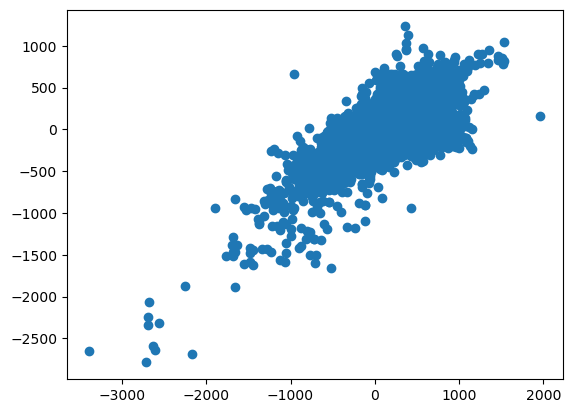

In [57]:
from matplotlib import pyplot as plt
model = CP_PLSR(9)  
model.fit(X_imputed, patient_response_DF)
Xnew = CPTensor((None, model.X_factors)).to_tensor()

fig,ax=plt.subplots()
ax.scatter(CoH_DF_PLS.values[Xmissing],Xnew[Xmissing])

from scipy.stats import pearsonr

score=pearsonr(CoH_DF_PLS.values[Xmissing],Xnew[Xmissing])
score

In [89]:
from tensorly import unfold
X_unfold_mode1=unfold(X.values,0)

In [90]:
ls = []
for i in range(X_unfold_mode1.shape[1]):
    if np.sum(np.isnan(X_unfold_mode1[:,i])) !=0:
        ls.append(i)

[Text(0.5, 0, 'Imputation Method'),
 Text(0, 0.5, 'R2'),
 Text(0.5, 1.0, 'Performance with 50% Missing Data')]

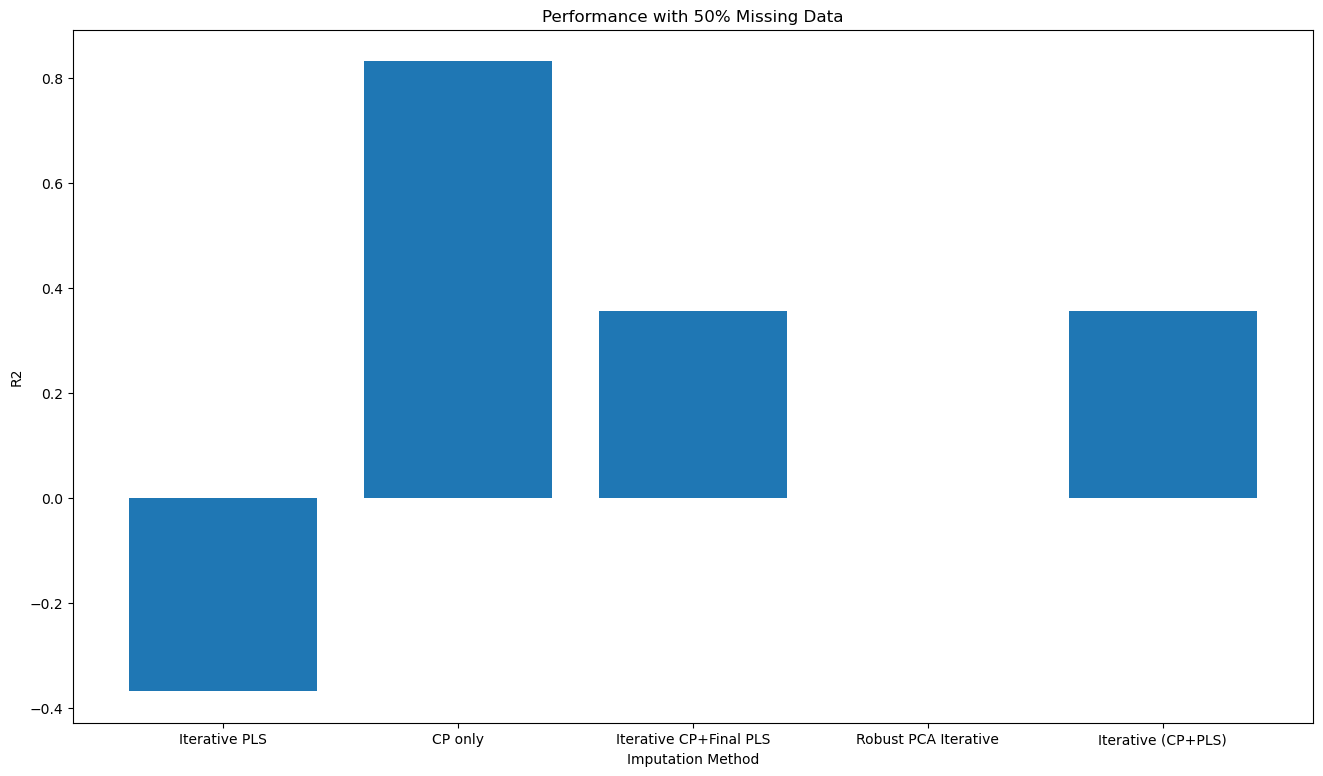

In [43]:
from matplotlib import pyplot as plt
fig,ax=plt.subplots(figsize=(16,9))

ax.bar(["Iterative PLS","CP only","Iterative CP+Final PLS","Robust PCA Iterative","Iterative (CP+PLS)"],performance_10,)
ax.set(xlabel="Imputation Method",ylabel="R2",title="Performance with 50% Missing Data")

In [29]:
performance_10=performance_10[0:4]
performance_10.insert(3,0)